## Filtering for CRN with neural martingales

### Chemical Reaction Network setup

In [1]:
import pandas as pd
from CRN_Simulation_Inference.RB_method_for_model_identification.RBForModelIdentification import RBForModelIdentification
import numpy as np
import matplotlib.pyplot as plt  
from tqdm import tqdm
import torch

species_names = ['G0', 'G1', 'mRNA']
stoichiometric_matrix = [[-1, 1, 0, 0],
                         [1, -1, 0, 0],
                         [0, 0, 1,-1]]
parameters_names = ['k1','k2', 'kp1']
reaction_names = ['G Act. 1', 'G Deg. 1', 'mRNA prod.', 'mRNA deg.']
propensities = [
    lambda k1, G0: k1*G0,
    lambda k2, G1: k2*G1,
    lambda kp1, G1: kp1*G1,
    lambda mRNA: mRNA
]

range_of_species = \
    pd.DataFrame([[0, 1], [0, 1], [0, 120] ], index=species_names, columns=['min', 'max'])
range_of_parameters= \
    pd.DataFrame([[0, 1], [0, 1], [0, 150]],index=parameters_names,columns=['min', 'max'])
discretization_size_parameters = \
    pd.DataFrame([21, 21, 151], index=parameters_names) #index=parameters_names

# The observation related information
# h_function = [
#     lambda Protein: Protein
# ]
h_function = [
    lambda mRNA: np.where(mRNA > 7, mRNA, 0)
]
observation_noise_intensity = [
    lambda : 1
]
#observation_noise_intensity = {'sigma1': 0.1}

maximum_size_of_each_follower_subsystem = 20000 #800 # 1000


MI = RBForModelIdentification(
    species_names=species_names,
    stoichiometric_matrix=stoichiometric_matrix,
    parameters_names=parameters_names,
    reaction_names=reaction_names,
    propensities=propensities,
    range_of_species=range_of_species,
    range_of_parameters=range_of_parameters,
    observation_noise_intensity=observation_noise_intensity,
    discretization_size_parameters=discretization_size_parameters,
    h_function=h_function,
    maximum_size_of_each_follower_subsystem=maximum_size_of_each_follower_subsystem)

print('leader species: ', MI.leader_species_time_course_data)
print('follower species: ', MI.get_follower_species_time_course_data())
print('follower parameters: ', MI.get_follower_parameters_time_course_data())

leader species:  ['G1']
follower species:  ['G0', 'mRNA']
follower parameters:  ['kp1', 'k2', 'k1']


setup parameters and simulate

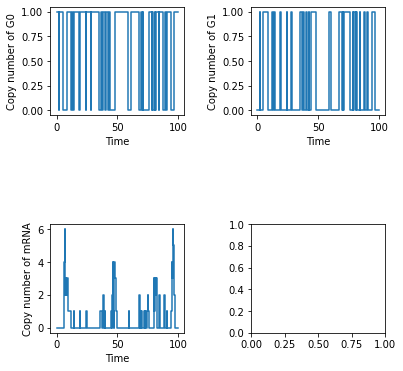

In [2]:
# Get a trajectory of the system
parameter_values_sets = []
parameter_values_sets.append({'k1': 0.3, 'k2': 0.4, 'kp1': 1}) # base parameters
parameter_values_sets.append({'k1': 0.3, 'k2': 0.8, 'kp1': 2})

parameter_set_index = 1
parameter_values = parameter_values_sets[parameter_set_index]
initial_state = {'G0': 1, 'G1': 0, 'mRNA': 0}
tf = 100
time_list, state_list, cPP = MI.SSA(initial_state, parameter_values, 0, tf, compute_centered_poisson_process=True)
MI.plot_trajectories(time_list, state_list)

# Generate the observations
dt = 1.
Observation_times_list = np.arange(dt, tf+dt, dt)
Y_list = MI.generate_observations(state_list, time_list, parameter_values, Observation_times_list)

visualize the centered Poisson Process

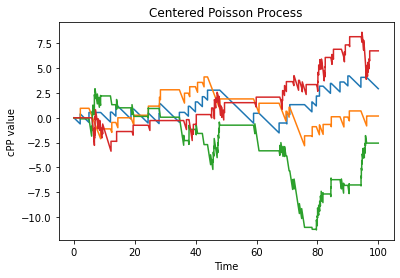

In [3]:
cPP.plot() 

For simplicity, we provide an helper function to prepare X, Y and the cPP through SSA simulations

In [4]:
# helper functions for defining the sampling times for the X and Y processes

def count_samples_for_supersampling(original, intensity):
    """ 
    Prepare supersampling for X ranges
    """
    x = original
    n_holes = x - 1
    x = intensity * n_holes + x
    return x

def get_X_Y_sampling_times(t0, tn, number_of_Y_samples, X_supersampling_intensity):
    """ 
    helper function to get sampling times for the X and Y processes
    """
    assert number_of_Y_samples % 2 == 1 and number_of_Y_samples > 1, "the number of mesurements must be odd and greater than 1 to include the extremes"
    assert X_supersampling_intensity > 0, "we require some supersampling on the X"
    forY = np.linspace(t0, tn, number_of_Y_samples)
    forX = np.linspace(t0, tn, count_samples_for_supersampling(number_of_Y_samples, X_supersampling_intensity))
    return forX, forY

def sample_trajectory_on_times(sampling_points, time_list, state_list):
    """ 
    sample a trajectory on specific time points
    """

    sampling_time_index = 0
    real_time_index = 0

    sampled_state_list = []

    while sampling_time_index < len(sampling_points):
        if real_time_index == len(time_list):
            sampled_state_list.append(state_list[real_time_index-1].copy())
            sampling_time_index += 1
        elif time_list[real_time_index] < sampling_points[sampling_time_index]:
            real_time_index += 1
        else:
            sampled_state_list.append(state_list[real_time_index-1].copy())
            sampling_time_index += 1

    return sampled_state_list


def CRN_simulations_to_dataloaders(data, batch_size, test_split=0.2, shuffle_dataset=True):
    """ 
    convert a dataset to a batched torch dataset
    """

    # torchify
    tX = torch.tensor(data["times_X"])
    tY = torch.tensor(data["times_Y"])
    Xs = torch.stack([torch.tensor(np.array(X)) for X in data["X"]])
    Ys = torch.stack([torch.tensor(np.array(Y)) for Y in data["Y"]])
    Rs = torch.stack([torch.tensor(np.array(R)) for R in data["R"]])

    dataset = torch.utils.data.TensorDataset(Xs, Ys, Rs)
    train_set, test_set = torch.utils.data.random_split(dataset, [int(len(dataset)*(1-test_split)), int(len(dataset)*test_split)])

    train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=batch_size, shuffle=shuffle_dataset)
    test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader, tX, tY


def run_SSA_for_filtering(MI, initial_state, parameter_values, t_fin, number_of_Y_samples, X_supersampling_intensity, t0=0, n_samples=1):
    """ 
    run multiple SSA simulations with the specified sampling strategy
    """

    X_sampling_times, Y_sampling_times = get_X_Y_sampling_times(t0, t_fin, number_of_Y_samples, X_supersampling_intensity)

    state_lists = []
    R_lists = []
    Y_lists = []

    for _ in tqdm(range(n_samples)):

        time_list, state_list, cPP = MI.SSA(initial_state, parameter_values, t0, t_fin, compute_centered_poisson_process=True)
        
        sampled_state_list = sample_trajectory_on_times(X_sampling_times, time_list, state_list)
        state_lists.append(sampled_state_list)
        # TODO check if R+ and R- are needed
        R = cPP.sample_at_times(X_sampling_times)
        R_lists.append(R)

        # Generate the observations
        Observation_times_list = Y_sampling_times
        Y_list = MI.generate_observations(state_list, time_list, parameter_values, Observation_times_list)
        Y_lists.append(Y_list)

    data = {"times_X" : X_sampling_times, "times_Y" : Y_sampling_times, "X" : state_lists, "Y" : Y_lists, "R" : R_lists}

    return data

### Debugging information

In [5]:
cPP.time_list

[0.0,
 2.0561890490117403,
 2.10915613058784,
 4.94234479372704,
 5.815697682155413,
 6.030685959107209,
 6.0565780487502,
 6.2474946261060635,
 6.723387527243553,
 6.724228912658067,
 6.729775505640468,
 6.785273800128053,
 6.923522812129555,
 6.94866688688142,
 6.972274454156466,
 7.0900378216260105,
 7.689728943910161,
 7.928431540505048,
 8.358804306441463,
 8.455635752720926,
 8.763560296960506,
 8.787738357022606,
 9.155433350492471,
 9.447098057419938,
 12.00299175053194,
 12.189975912548324,
 12.444682357108976,
 13.778549383365466,
 14.015345013408592,
 14.030831931296307,
 14.435554822208838,
 18.747375266760628,
 19.087445046856466,
 19.456652783602507,
 19.679516127311302,
 24.363654471855938,
 24.436094425691095,
 24.464757478079385,
 24.961925872412365,
 27.97251374209615,
 28.10276202293024,
 28.11375490439421,
 28.42378808009086,
 34.64896851891877,
 36.062290803431544,
 36.325749927569404,
 36.96920878501974,
 37.605509013748986,
 37.80036003613728,
 37.83140491445415,

In [6]:
cPP.current_a

[array([0.3, 0. , 0. , 0. ]),
 array([0.3, 0. , 0. , 0. ]),
 array([0. , 0.8, 2. , 0. ]),
 array([0.3, 0. , 0. , 0. ]),
 array([0. , 0.8, 2. , 0. ]),
 array([0. , 0.8, 2. , 1. ]),
 array([0. , 0.8, 2. , 2. ]),
 array([0. , 0.8, 2. , 3. ]),
 array([0. , 0.8, 2. , 4. ]),
 array([0. , 0.8, 2. , 5. ]),
 array([0. , 0.8, 2. , 6. ]),
 array([0. , 0.8, 2. , 5. ]),
 array([0. , 0.8, 2. , 4. ]),
 array([0. , 0.8, 2. , 5. ]),
 array([0. , 0.8, 2. , 4. ]),
 array([0. , 0.8, 2. , 3. ]),
 array([0. , 0.8, 2. , 2. ]),
 array([0. , 0.8, 2. , 3. ]),
 array([0. , 0.8, 2. , 2. ]),
 array([0. , 0.8, 2. , 3. ]),
 array([0. , 0.8, 2. , 2. ]),
 array([0. , 0.8, 2. , 3. ]),
 array([0.3, 0. , 0. , 3. ]),
 array([0.3, 0. , 0. , 2. ]),
 array([0.3, 0. , 0. , 1. ]),
 array([0. , 0.8, 2. , 1. ]),
 array([0. , 0.8, 2. , 0. ]),
 array([0.3, 0. , 0. , 0. ]),
 array([0. , 0.8, 2. , 0. ]),
 array([0. , 0.8, 2. , 1. ]),
 array([0. , 0.8, 2. , 0. ]),
 array([0.3, 0. , 0. , 0. ]),
 array([0. , 0.8, 2. , 0. ]),
 array([0.

In [7]:
cPP.centered_PP_mean

[array([0., 0., 0., 0.]),
 array([0.61685671, 0.        , 0.        , 0.        ]),
 array([0.61685671, 0.04237367, 0.10593416, 0.        ]),
 array([1.46681331, 0.04237367, 0.10593416, 0.        ]),
 array([1.46681331, 0.74105598, 1.85263994, 0.        ]),
 array([1.46681331, 0.9130466 , 2.28261649, 0.21498828]),
 array([1.46681331, 0.93376027, 2.33440067, 0.26677246]),
 array([1.46681331, 1.08649353, 2.71623383, 0.83952219]),
 array([1.46681331, 1.46720785, 3.66801963, 2.74309379]),
 array([1.46681331, 1.46788096, 3.6697024 , 2.74730072]),
 array([1.46681331, 1.47231823, 3.68079559, 2.78058028]),
 array([1.46681331, 1.51671687, 3.79179218, 3.05807175]),
 array([1.46681331, 1.62731608, 4.0682902 , 3.6110678 ]),
 array([1.46681331, 1.64743134, 4.11857835, 3.73678817]),
 array([1.46681331, 1.66631739, 4.16579348, 3.83121844]),
 array([1.46681331, 1.76052809, 4.40132022, 4.18450854]),
 array([1.46681331, 2.24028099, 5.60070246, 5.38389079]),
 array([1.46681331, 2.43124306, 6.07810766, 6.

In [8]:
cPP.centered_PP

[array([0., 0., 0., 0.]),
 array([0.38314329, 0.        , 0.        , 0.        ]),
 array([ 0.38314329,  0.95762633, -0.10593416,  0.        ]),
 array([ 0.53318669,  0.95762633, -0.10593416,  0.        ]),
 array([ 0.53318669,  0.25894402, -0.85263994,  0.        ]),
 array([ 0.53318669,  0.0869534 , -0.28261649, -0.21498828]),
 array([ 0.53318669,  0.06623973,  0.66559933, -0.26677246]),
 array([ 0.53318669, -0.08649353,  1.28376617, -0.83952219]),
 array([ 0.53318669, -0.46720785,  1.33198037, -2.74309379]),
 array([ 0.53318669, -0.46788096,  2.3302976 , -2.74730072]),
 array([ 0.53318669, -0.47231823,  2.31920441, -1.78058028]),
 array([ 0.53318669, -0.51671687,  2.20820782, -1.05807175]),
 array([ 0.53318669, -0.62731608,  2.9317098 , -1.6110678 ]),
 array([ 0.53318669, -0.64743134,  2.88142165, -0.73678817]),
 array([ 0.53318669, -0.66631739,  2.83420652,  0.16878156]),
 array([ 0.53318669, -0.76052809,  2.59867978,  0.81549146]),
 array([ 0.53318669, -1.24028099,  2.39929754, -

In [9]:
cPP.sample_at_times([9.99, 10., 10.01])

array([[ 0.17250819, -1.11868852,  2.20327871, -1.16893805],
       [ 0.16950819, -1.11868852,  2.20327871, -1.17893805],
       [ 0.16650819, -1.11868852,  2.20327871, -1.18893805]])

In [10]:
print(cPP.at(9.99))
print(cPP.at(10.01))

[ 0.17250819 -1.11868852  2.20327871 -1.71184   ]
[ 0.16650819 -1.11868852  2.20327871 -1.75184   ]


In [11]:
cPP.centered_PP_actual

[array([0., 0., 0., 0.]),
 array([1., 0., 0., 0.]),
 array([1., 1., 0., 0.]),
 array([2., 1., 0., 0.]),
 array([2., 1., 1., 0.]),
 array([2., 1., 2., 0.]),
 array([2., 1., 3., 0.]),
 array([2., 1., 4., 0.]),
 array([2., 1., 5., 0.]),
 array([2., 1., 6., 0.]),
 array([2., 1., 6., 1.]),
 array([2., 1., 6., 2.]),
 array([2., 1., 7., 2.]),
 array([2., 1., 7., 3.]),
 array([2., 1., 7., 4.]),
 array([2., 1., 7., 5.]),
 array([2., 1., 8., 5.]),
 array([2., 1., 8., 6.]),
 array([2., 1., 9., 6.]),
 array([2., 1., 9., 7.]),
 array([ 2.,  1., 10.,  7.]),
 array([ 2.,  2., 10.,  7.]),
 array([ 2.,  2., 10.,  8.]),
 array([ 2.,  2., 10.,  9.]),
 array([ 3.,  2., 10.,  9.]),
 array([ 3.,  2., 10., 10.]),
 array([ 3.,  3., 10., 10.]),
 array([ 4.,  3., 10., 10.]),
 array([ 4.,  3., 11., 10.]),
 array([ 4.,  3., 11., 11.]),
 array([ 4.,  4., 11., 11.]),
 array([ 5.,  4., 11., 11.]),
 array([ 5.,  4., 12., 11.]),
 array([ 5.,  4., 12., 12.]),
 array([ 5.,  5., 12., 12.]),
 array([ 6.,  5., 12., 12.]),


In [12]:
len(cPP.time_list)

164

In [13]:
np.searchsorted(np.array(cPP.time_list), 0.01, side='right') - 1

0

In [14]:
cPP.time_list

[0.0,
 2.0561890490117403,
 2.10915613058784,
 4.94234479372704,
 5.815697682155413,
 6.030685959107209,
 6.0565780487502,
 6.2474946261060635,
 6.723387527243553,
 6.724228912658067,
 6.729775505640468,
 6.785273800128053,
 6.923522812129555,
 6.94866688688142,
 6.972274454156466,
 7.0900378216260105,
 7.689728943910161,
 7.928431540505048,
 8.358804306441463,
 8.455635752720926,
 8.763560296960506,
 8.787738357022606,
 9.155433350492471,
 9.447098057419938,
 12.00299175053194,
 12.189975912548324,
 12.444682357108976,
 13.778549383365466,
 14.015345013408592,
 14.030831931296307,
 14.435554822208838,
 18.747375266760628,
 19.087445046856466,
 19.456652783602507,
 19.679516127311302,
 24.363654471855938,
 24.436094425691095,
 24.464757478079385,
 24.961925872412365,
 27.97251374209615,
 28.10276202293024,
 28.11375490439421,
 28.42378808009086,
 34.64896851891877,
 36.062290803431544,
 36.325749927569404,
 36.96920878501974,
 37.605509013748986,
 37.80036003613728,
 37.83140491445415,

In [15]:
cPP.centered_PP

[array([0., 0., 0., 0.]),
 array([0.38314329, 0.        , 0.        , 0.        ]),
 array([ 0.38314329,  0.95762633, -0.10593416,  0.        ]),
 array([ 0.53318669,  0.95762633, -0.10593416,  0.        ]),
 array([ 0.53318669,  0.25894402, -0.85263994,  0.        ]),
 array([ 0.53318669,  0.0869534 , -0.28261649, -0.21498828]),
 array([ 0.53318669,  0.06623973,  0.66559933, -0.26677246]),
 array([ 0.53318669, -0.08649353,  1.28376617, -0.83952219]),
 array([ 0.53318669, -0.46720785,  1.33198037, -2.74309379]),
 array([ 0.53318669, -0.46788096,  2.3302976 , -2.74730072]),
 array([ 0.53318669, -0.47231823,  2.31920441, -1.78058028]),
 array([ 0.53318669, -0.51671687,  2.20820782, -1.05807175]),
 array([ 0.53318669, -0.62731608,  2.9317098 , -1.6110678 ]),
 array([ 0.53318669, -0.64743134,  2.88142165, -0.73678817]),
 array([ 0.53318669, -0.66631739,  2.83420652,  0.16878156]),
 array([ 0.53318669, -0.76052809,  2.59867978,  0.81549146]),
 array([ 0.53318669, -1.24028099,  2.39929754, -

In [16]:
cPP.sample_at_times([9.99, 10.01])

array([[ 0.17250819, -1.11868852,  2.20327871, -1.16893805],
       [ 0.16650819, -1.11868852,  2.20327871, -1.18893805]])

In [17]:
cPP.at(9.99)

array([ 0.17250819, -1.11868852,  2.20327871, -1.71184   ])

In [18]:
np.searchsorted(np.array(cPP.time_list), 9.99, side='right') - 1

23

### Dataloader structure

Let $\mathcal{T}$ be the set of measurement times, $\Tau$ the time discretization set, and $\mathcal{R}$ be the set of reactions. The dataloader should contain:

* $X(t) \forall t\in\Tau$ the full process 
* $Y(t) \forall t\in\mathcal{T}$ the observed process
* $\tilde{R}_k(t) \forall t\in\Tau, k\in \mathcal{R}$ the centered poisson process associated to the reaction $k$ 

this implies the following tensor dimensions (we condiser the batch size $B$) of the input tensors, respectively:

* $[B, |\Tau|, |X|]$
* $[B, |\mathcal{T}|, |y|]$
* $[B, |\Tau|, |r|]$


In [19]:
# this can be done quickly by running 

n_samples = 100
batch_size = 10

dataset = run_SSA_for_filtering(MI, initial_state, parameter_values, tf, 11, 1, n_samples=n_samples)
train_dataset, val_dataset, Xtimes, Ytimes = CRN_simulations_to_dataloaders(dataset, batch_size)

[ x.shape for x in next(iter(train_dataset))]

100%|██████████| 100/100 [00:01<00:00, 72.98it/s]


[torch.Size([10, 21, 3]), torch.Size([10, 11, 1]), torch.Size([10, 21, 4])]

#### TODO list

* prepare likelihood computatons
* consider slicing mechanism, and timepoint slicing and converions
* for cPP, verify when needed, and apply more strict sampling frequency
* implement a simple NN for the loss function
* mmmmmmmmmm


### Neural Network setup

We omit the definition of the CRN, which is done at the beginning of the file

In [20]:
from ElenaNetworks import MLP, RNNEncoder, NeuralMartingale

Delta = torch.tensor(MI.stoichiometric_matrix)

# we need a version of the h_function that is efficient for torch computations (maybe?)

XEncoder = MLP(MI.get_number_of_species(), 16, 16, 3)
YEncoder = RNNEncoder(len(h_function), 16)
backbone = MLP(1+XEncoder.output_size+YEncoder.embedding_size, 16, 1, 2)

NN = NeuralMartingale(XEncoder, YEncoder, backbone)
NN

NeuralMartingale(
  (X_encoder): MLP(
    (layers): Sequential(
      (0): Linear(in_features=3, out_features=16, bias=True)
      (1): Tanh()
      (2): Sequential(
        (0): Linear(in_features=16, out_features=16, bias=True)
        (1): Tanh()
      )
      (3): Sequential(
        (0): Linear(in_features=16, out_features=16, bias=True)
        (1): Tanh()
      )
      (4): Linear(in_features=16, out_features=16, bias=True)
    )
  )
  (Y_encoder): RNNEncoder(
    (RNN): LSTM(1, 16, batch_first=True)
  )
  (backbone): MLP(
    (layers): Sequential(
      (0): Linear(in_features=33, out_features=16, bias=True)
      (1): Tanh()
      (2): Sequential(
        (0): Linear(in_features=16, out_features=16, bias=True)
        (1): Tanh()
      )
      (3): Linear(in_features=16, out_features=1, bias=True)
    )
  )
)

### Training loop

now we have to define the training loop

In [21]:
def likelihood_GaussianNoise(Y, X, h_transform, parameters):
    # define parameters as a dictionary when defining likelihood functions
    # the parameters are X, h_transform, noise_covariance
    hx = h_transform(X)
    return torch.nn.functional.gaussian_nll_loss(Y, hx, parameters["noise_covariance"], full=True, reduction='none')






def inner_loop(model, tk)
    
    ILL = 0. # inner loop loss
    for j in range(model.stoichiometric_matrix.shape[0]):
        ILL += model.stoichiometric_matrix[j,:] * model(tk+)

    return ILL

def MartingaleLoss(model, likelihood_function, X, Y, R..):
    # time is at the second dimension (batch, time, components)
    base_case_G = likelihood_function(Y[:, -1, :], X[:, -1, :], model.h_transform, model.noise_covariance)*model.g_function(X[:, -1, :])



    
    
    



SyntaxError: invalid syntax (<ipython-input-21-6dbd2f04c9a2>, line 8)